<a href="https://colab.research.google.com/github/singwang-cn/Neural-Network/blob/master/audio_processing_with_DFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pydub

In [ ]:
from pydub import AudioSegment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Step 1 Preparation of Data Set
The first thing to do is preparing the data. There are 150 pieces of voice and 3 longer ones from three differet people in the data used for this task. And we also need to define a function for Discrete Fourier Transform to process the data set.

In [ ]:
sound_list = []
for i in range(50):
  sound = AudioSegment.from_file("/content/drive/My Drive/Dataset/audio/wzq{}.m4a".format(i+1), "m4a")
  samples = np.array(sound.get_array_of_samples())
  sound_list.append(samples[::sound.channels])
for i in range(50):
  sound = AudioSegment.from_file("/content/drive/My Drive/Dataset/audio/lx{}.m4a".format(i+1), "m4a")
  samples = np.array(sound.get_array_of_samples())
  sound_list.append(samples[::sound.channels])
for i in range(50):
  sound = AudioSegment.from_file("/content/drive/My Drive/Dataset/audio/zty{}.m4a".format(i+1), "m4a")
  samples = np.array(sound.get_array_of_samples())
  sound_list.append(samples[::sound.channels])

In [ ]:
def Discrete_Fourier_Transform(sample):
  M = 10
  Fourier_Matrix = np.zeros([M, M], dtype=complex)
  for k in range(M):
    for n in range(M):
      Fourier_Matrix[k][n] = np.exp((0-1j)*2*np.pi/M*k*n)
  
  start = 0
  D = np.zeros(M)
  for i in range(int(len(sample) / M)):
    D += abs(np.dot(sample[start:start+M], Fourier_Matrix)) / M
    start += M

  return D / int(len(sample))

Demonstration of the sounds tansformed to digital signal

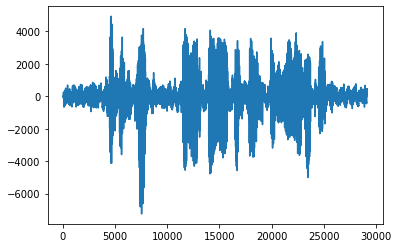

In [ ]:
sound = AudioSegment.from_file("/content/drive/My Drive/Dataset/audio/Test_record_for_DFT.m4a", "m4a")
samples = np.array(sound.get_array_of_samples())
sample = samples[::sound.channels]
plt.plot(sample[::10])

<BarContainer object of 10 artists>

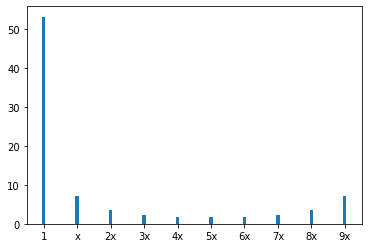

In [ ]:
plt.bar(['1', 'x', '2x', '3x', '4x', '5x', '6x', '7x', '8x', '9x'], Discrete_Fourier_Transform(sample), 0.1)

To computer the coefficients of DFT and transform them into Tensor.

In [ ]:
coefficient_dft = []
for sound_instance in sound_list:
  coefficient_dft.append(Discrete_Fourier_Transform(sound_instance))

x = torch.Tensor(np.array(coefficient_dft)[:, 1:10])
y = torch.Tensor([[1, 0, 0] for i in range(50)]+[[0, 1, 0] for i in range(50)]+[[0, 0, 1] for i in range(50)])

# Step 2 Building a Deep Neural Network and Training
The DNN with 10 neurons times 9 layers is used to recognize the sounds from different people.

In [ ]:
input = 9
neuron = 10
output = 3
model = torch.nn.Sequential(
  torch.nn.Linear(input, neuron),
  torch.nn.Sigmoid(),
  torch.nn.Linear(neuron, neuron),
  torch.nn.Sigmoid(),
  torch.nn.Linear(neuron, neuron),
  torch.nn.Sigmoid(),
  torch.nn.Linear(neuron, neuron),
  torch.nn.Sigmoid(),
  torch.nn.Linear(neuron, neuron),
  torch.nn.Sigmoid(),
  torch.nn.Linear(neuron, neuron),
  torch.nn.Sigmoid(),
  torch.nn.Linear(neuron, neuron),
  torch.nn.Sigmoid(),
  torch.nn.Linear(neuron, neuron),
  torch.nn.Sigmoid(),
  torch.nn.Linear(neuron, neuron),
  torch.nn.Sigmoid(),
  torch.nn.Linear(neuron, output),
  torch.nn.Softmax(dim=1)
)
cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)

Training

In [ ]:
for i in range(1500):
  y_pre = model(x)
  loss = cost_function(y_pre, y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
print(loss)

tensor(0.0312, grad_fn=<MseLossBackward>)


# Step 3 validation
Because there are not suffient data in this task, resubstitution is used to valid the result.

In [ ]:
pre_result = np.argmax(model(x).data.numpy(), axis=1)
real_result = np.argmax(y.data.numpy(), axis=1)
result = (pre_result == real_result)

print('quantity: {} / {}'.format(result.sum(), result.shape[0]))
print('accuracy: {:.2%}'.format(result.sum() / result.shape[0]))

quantity: 140 / 150
accuracy: 93.33%


Finally, try to classify the longer sounds and say whose voice it is.

In [ ]:
vec2name = {0: 'WANG ZHAOQING', 1: 'LI XIN', 2: 'ZHANG TINGYAO'}
sound1 = AudioSegment.from_file("/content/drive/My Drive/Dataset/audio/wzq_validate.m4a", "m4a")
samples1 = np.array(sound1.get_array_of_samples())
sample1 = samples1[::sound1.channels]
index1 = np.argmax(model(torch.Tensor([Discrete_Fourier_Transform(sample1)[1:10]])).data.numpy(), axis=1)[0]
sound2 = AudioSegment.from_file("/content/drive/My Drive/Dataset/audio/lx_validate.m4a", "m4a")
samples2 = np.array(sound2.get_array_of_samples())
sample2 = samples2[::sound2.channels]
index2 = np.argmax(model(torch.Tensor([Discrete_Fourier_Transform(sample2)[1:10]])).data.numpy(), axis=1)[0]
sound3 = AudioSegment.from_file("/content/drive/My Drive/Dataset/audio/zty_validate.m4a", "m4a")
samples3 = np.array(sound3.get_array_of_samples())
sample3 = samples2[::sound3.channels]
index3 = np.argmax(model(torch.Tensor([Discrete_Fourier_Transform(sample3)[1:10]])).data.numpy(), axis=1)[0]
print('''
The 1st piece of test sound belongs to {}.\n
The 2nd piece of test sound belongs to {}.\n
The 3rd piece of test sound belongs to {}.\n
'''.format(vec2name[index1], vec2name[index2], vec2name[index3]))


The 1st piece of test sound belongs to WANG ZHAOQING.

The 2nd piece of test sound belongs to LI XIN.

The 3rd piece of test sound belongs to ZHANG TINGYAO.


